# Sparse Dense and Hybrid Search

Dense Search 

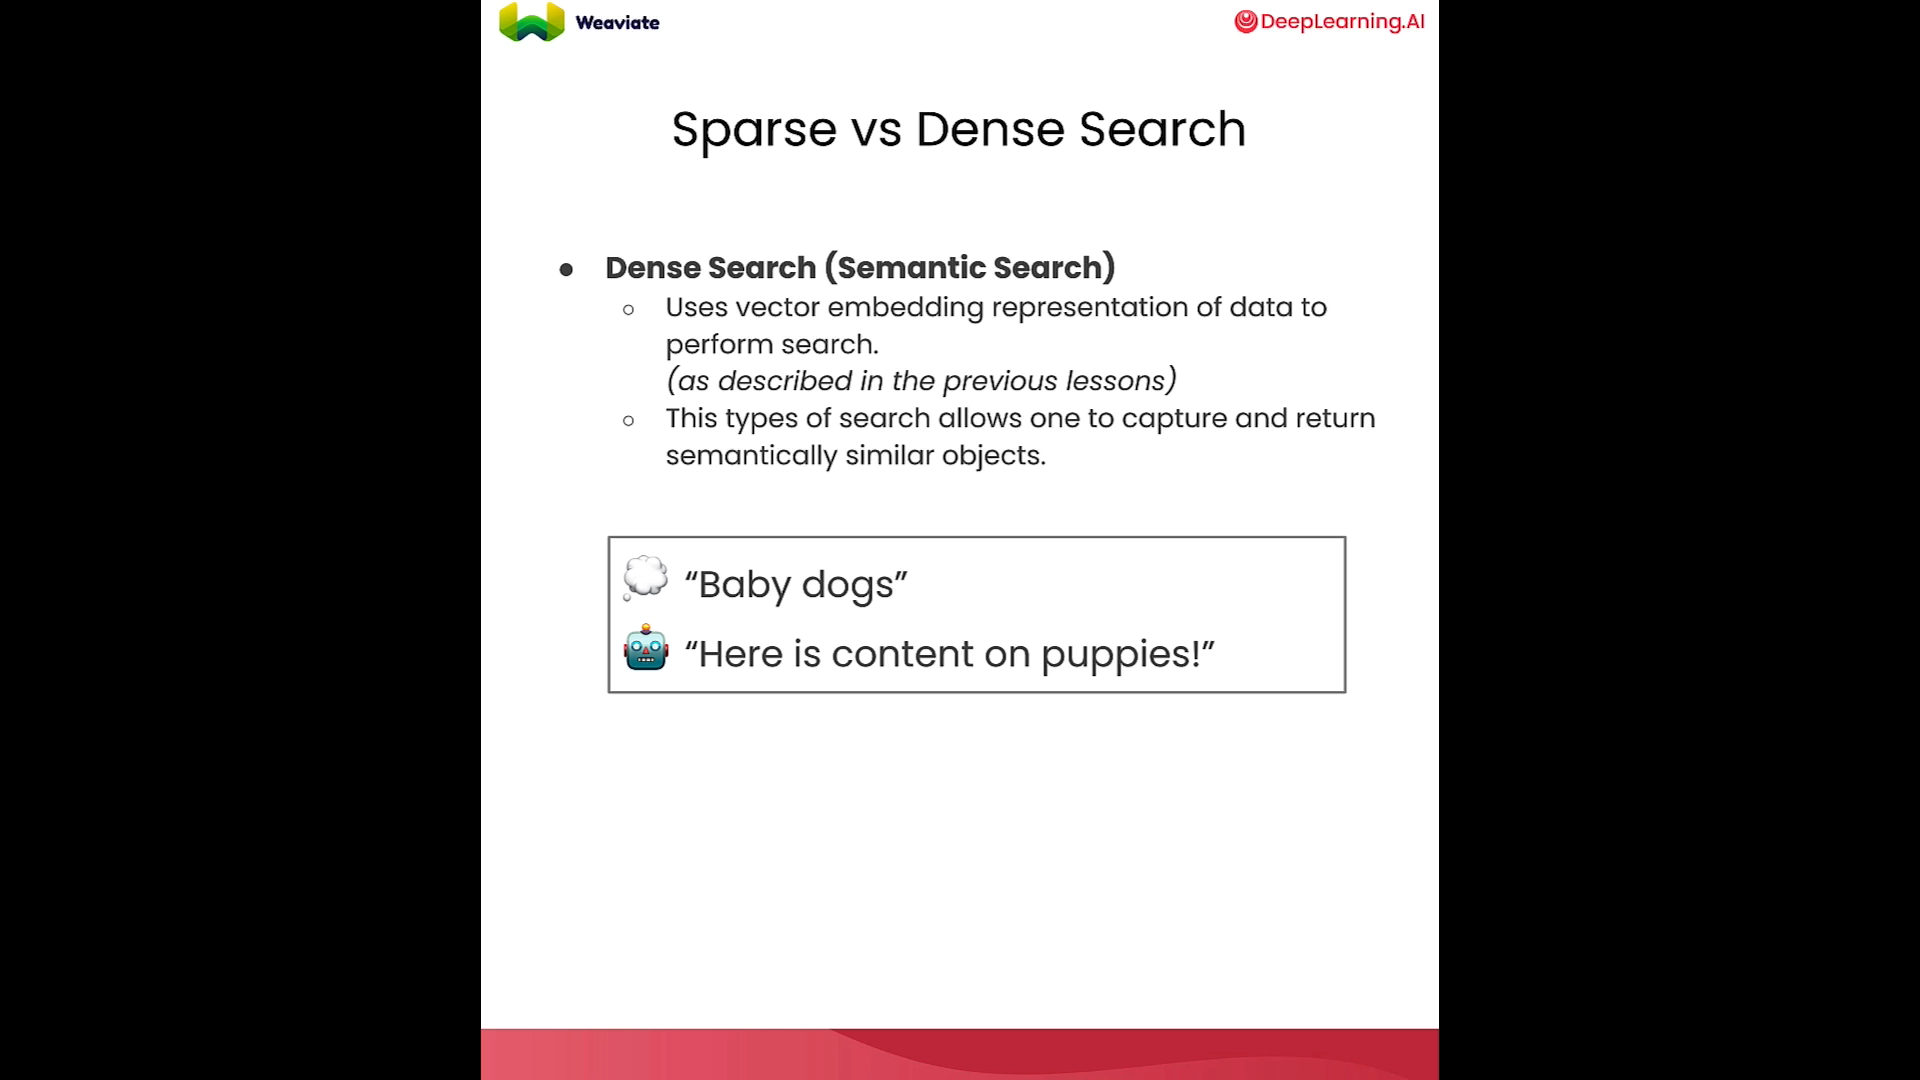

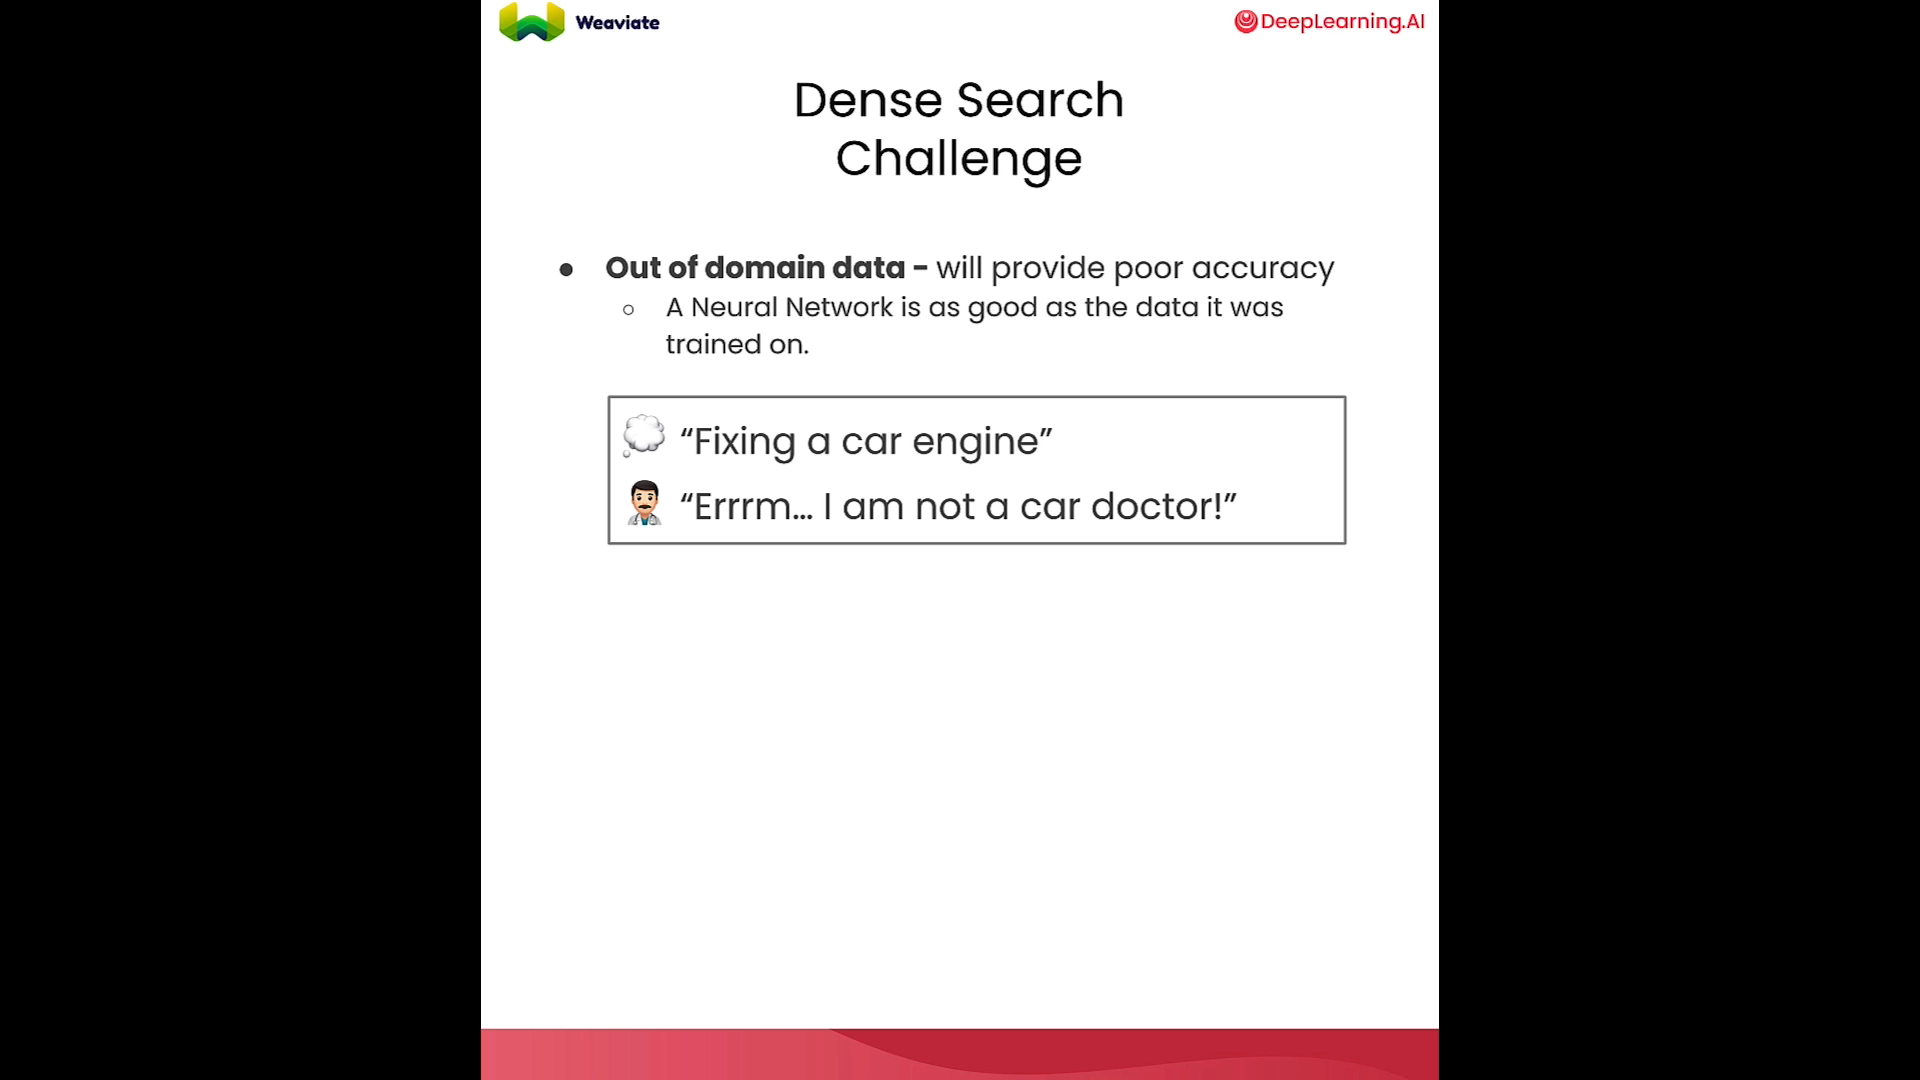

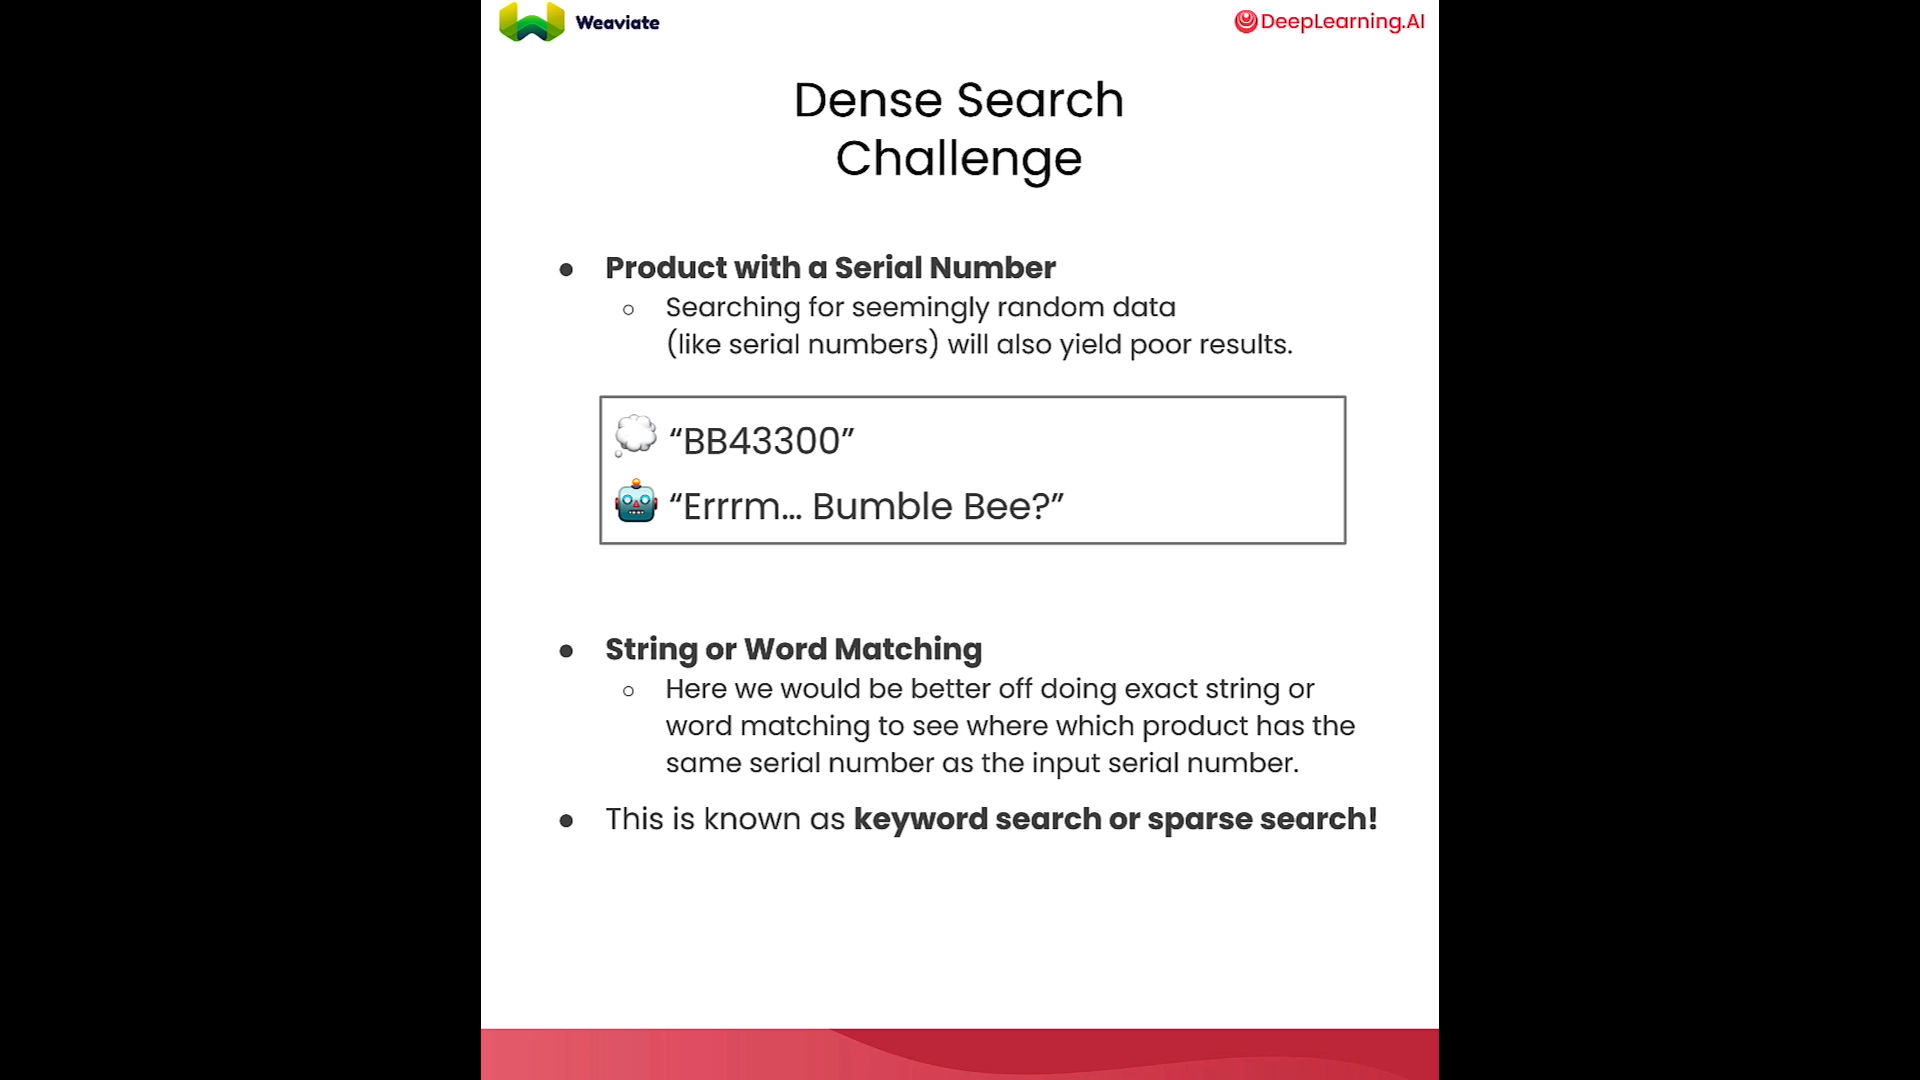

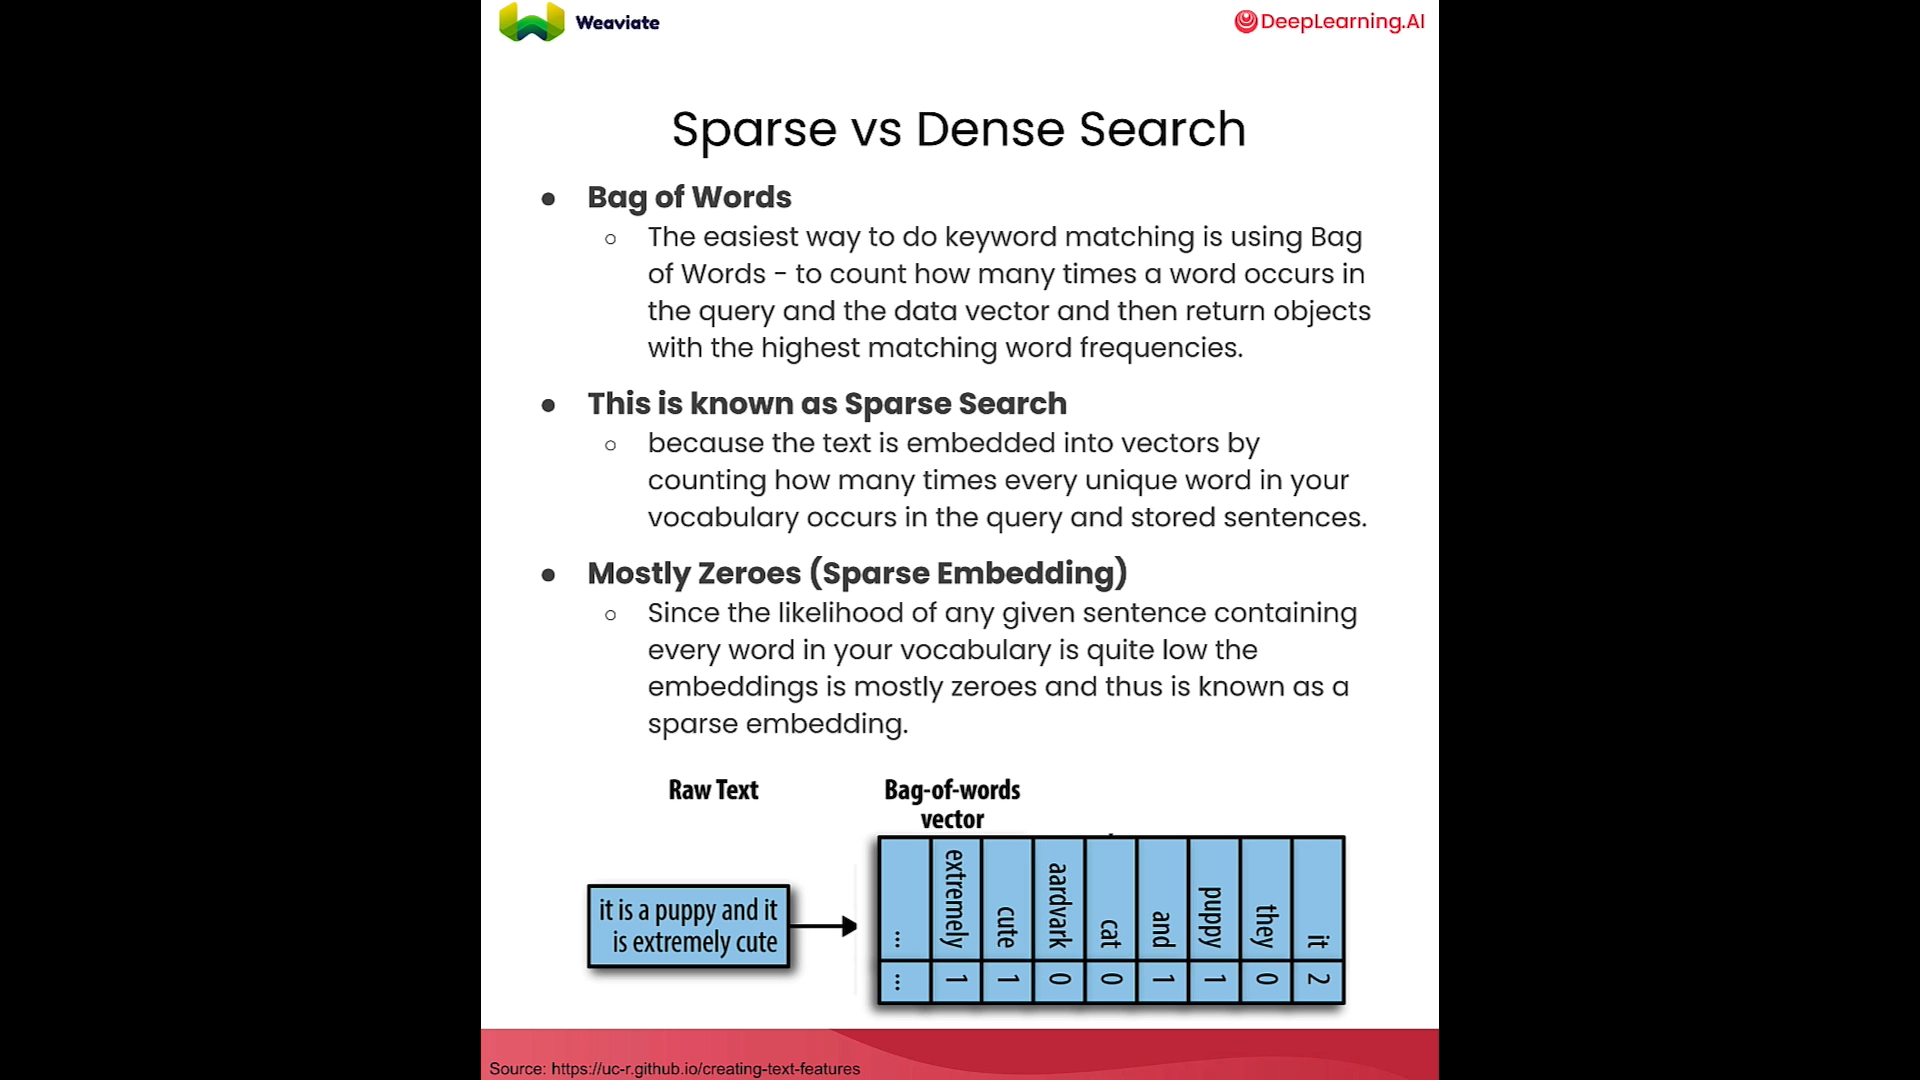

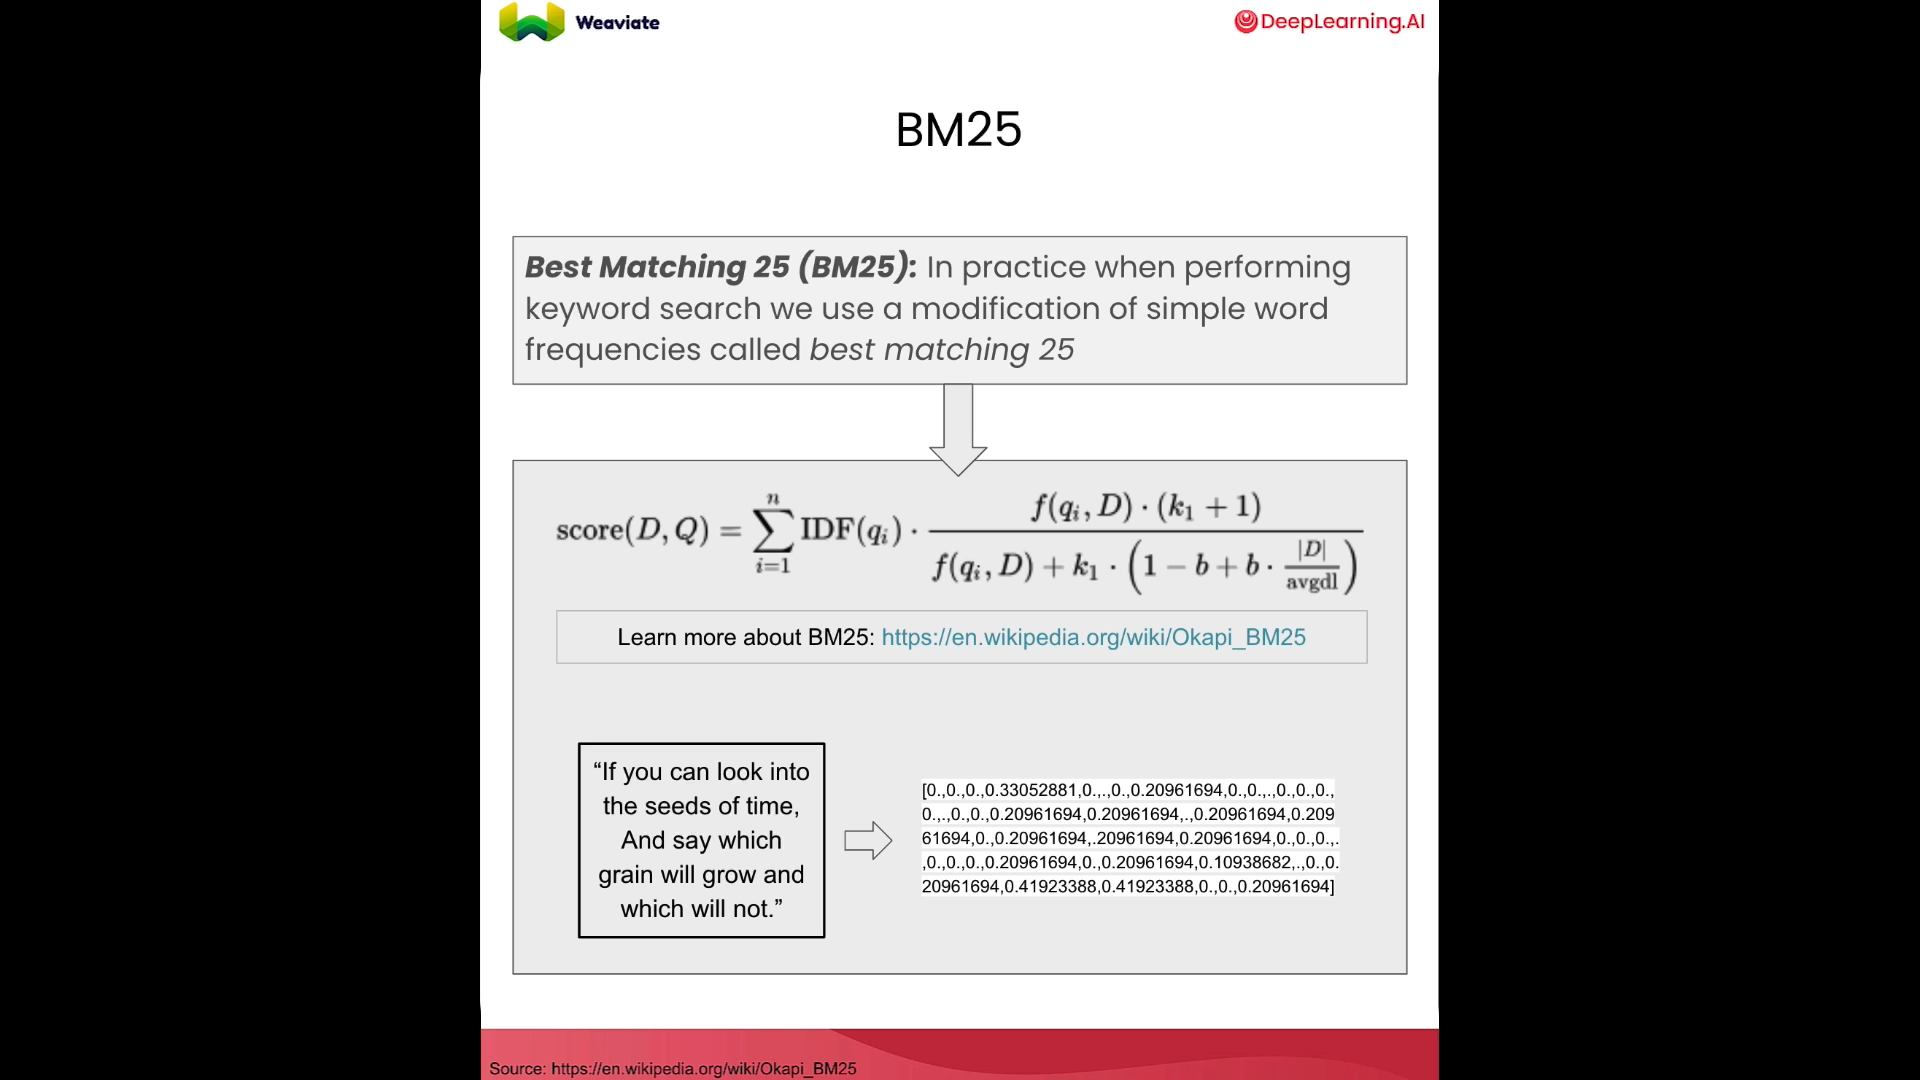

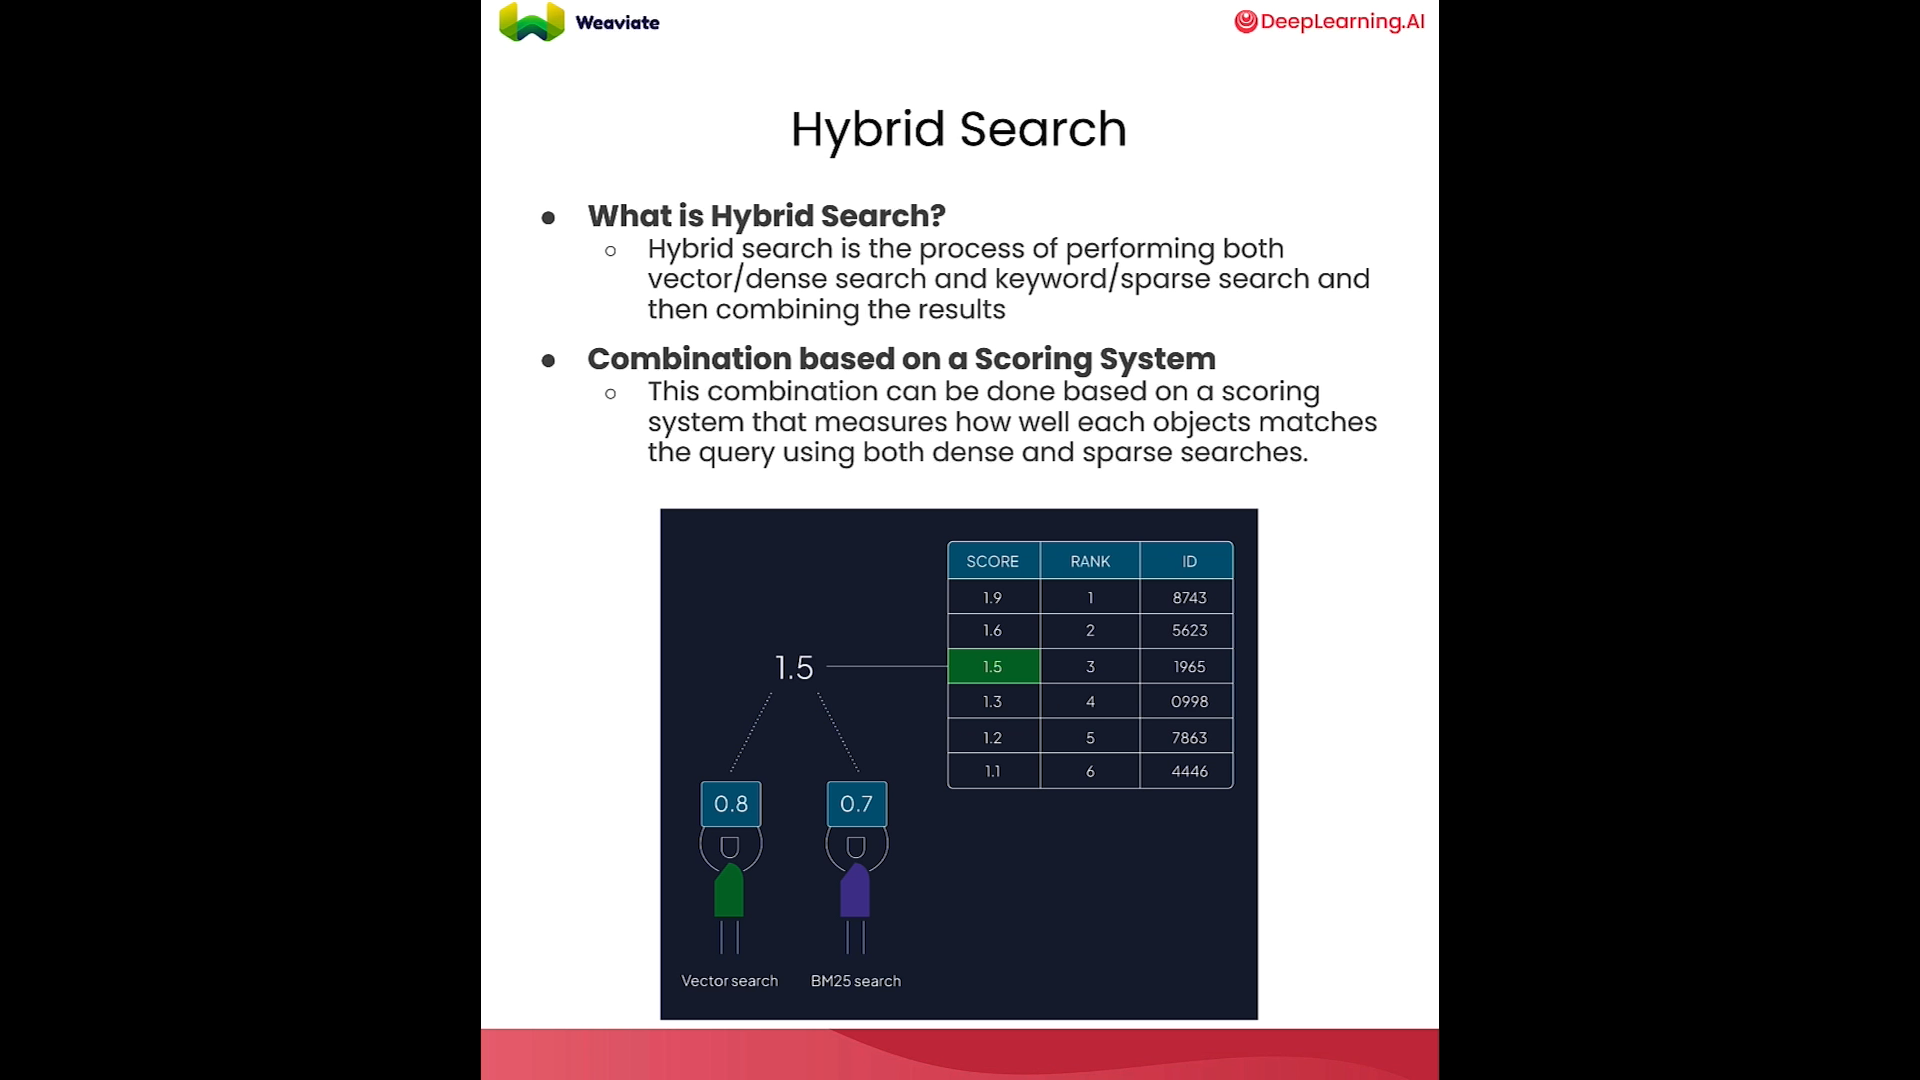

## Remove old Weaviate DB files

In [ ]:
!rm -rf ~/.local/share/weaviate

## Recreate the example
With the same data as in the previous lesson

In [1]:
import requests
import json

# Download the data
resp = requests.get('https://raw.githubusercontent.com/weaviate-tutorials/quickstart/main/data/jeopardy_tiny.json')
data = json.loads(resp.text)  # Load data

# Parse the JSON and preview it
print(type(data), len(data))

def json_print(data):
    print(json.dumps(data, indent=2))

<class 'list'> 10


In [2]:
import weaviate, os
from weaviate import EmbeddedOptions
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

client = weaviate.Client(
    embedded_options=EmbeddedOptions(),
    additional_headers={
        "X-OpenAI-Api-BaseURL": os.environ['OPENAI_API_BASE'],
        "X-OpenAI-Api-Key": openai.api_key,  # Replace this with your actual key
    }
)
print(f"Client created? {client.is_ready()}")

Binary /home/jovyan/.cache/weaviate-embedded did not exist. Downloading binary from https://github.com/weaviate/weaviate/releases/download/v1.22.3/weaviate-v1.22.3-Linux-amd64.tar.gz
Started /home/jovyan/.cache/weaviate-embedded: process ID 62
Client created? True


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2023-12-29T11:03:36Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2023-12-29T11:03:36Z"}
{"level":"warning","msg":"Multiple vector spaces are present, GraphQL Explore and REST API list objects endpoint module include params has been disabled as a result.","time":"2023-12-29T11:03:36Z"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50060","time":"2023-12-29T11:03:36Z"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://127.0.0.1:8079","time":"2023-12-29T11:03:36Z"}


In [3]:
# Uncomment the following two lines if you want to run this block for a second time.
if client.schema.exists("Question"):
   client.schema.delete_class("Question")
 
class_obj = {
    "class": "Question",
    "vectorizer": "text2vec-openai",  # Use OpenAI as the vectorizer
    "moduleConfig": {
        "text2vec-openai": {
            "model": "ada",
            "modelVersion": "002",
            "type": "text",
            "baseURL": os.environ["OPENAI_API_BASE"]
        }
    }
}

client.schema.create_class(class_obj)

{"action":"hnsw_vector_cache_prefill","count":1000,"index_id":"question_WZJl1qUtNnlY","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2023-12-29T11:03:36Z","took":131052}


In [4]:
with client.batch.configure(batch_size=5) as batch:
    for i, d in enumerate(data):  # Batch import data
        
        print(f"importing question: {i+1}")
        
        properties = {
            "answer": d["Answer"],
            "question": d["Question"],
            "category": d["Category"],
        }
        
        batch.add_data_object(
            data_object=properties,
            class_name="Question"
        )

importing question: 1
importing question: 2
importing question: 3
importing question: 4
importing question: 5
importing question: 6
importing question: 7
importing question: 8
importing question: 9
importing question: 10


## Queries

### Dense Search

In [5]:
response = (
    client.query
    .get("Question", ["question", "answer"])
    .with_near_text({"concepts":["animal"]})
    .with_limit(3)
    .do()
)

json_print(response) ## Semantically we got all answer

{
  "data": {
    "Get": {
      "Question": [
        {
          "answer": "Elephant",
          "question": "It's the only living mammal in the order Proboseidea"
        },
        {
          "answer": "the nose or snout",
          "question": "The gavial looks very much like a crocodile except for this bodily feature"
        },
        {
          "answer": "Antelope",
          "question": "Weighing around a ton, the eland is the largest species of this animal in Africa"
        }
      ]
    }
  }
}


### Sparse Search - BM25

In [6]:
response = (
    client.query
    .get("Question",["question","answer"])
    .with_bm25(query="animal")
    .with_limit(3)
    .do()
)

json_print(response) ## This will not work well .But we do get animal

{
  "data": {
    "Get": {
      "Question": [
        {
          "answer": "Antelope",
          "question": "Weighing around a ton, the eland is the largest species of this animal in Africa"
        }
      ]
    }
  }
}


### Hybrid Search

In [9]:
response = (
    client.query
    .get("Question",["question","answer"])
    .with_hybrid(query="animal", alpha=0.5)
    .with_limit(3)
    .do()
)

json_print(response)

{
  "data": {
    "Get": {
      "Question": [
        {
          "answer": "Antelope",
          "question": "Weighing around a ton, the eland is the largest species of this animal in Africa"
        },
        {
          "answer": "Elephant",
          "question": "It's the only living mammal in the order Proboseidea"
        },
        {
          "answer": "the nose or snout",
          "question": "The gavial looks very much like a crocodile except for this bodily feature"
        }
      ]
    }
  }
}


In [10]:
response = (
    client.query
    .get("Question",["question","answer"])
    .with_hybrid(query="animal", alpha=0)
    .with_limit(3)
    .do()
)

json_print(response)

{
  "data": {
    "Get": {
      "Question": [
        {
          "answer": "Antelope",
          "question": "Weighing around a ton, the eland is the largest species of this animal in Africa"
        }
      ]
    }
  }
}


In [11]:
response = (
    client.query
    .get("Question",["question","answer"])
    .with_hybrid(query="animal", alpha=1)
    .with_limit(3)
    .do()
)

json_print(response)

{
  "data": {
    "Get": {
      "Question": [
        {
          "answer": "Elephant",
          "question": "It's the only living mammal in the order Proboseidea"
        },
        {
          "answer": "the nose or snout",
          "question": "The gavial looks very much like a crocodile except for this bodily feature"
        },
        {
          "answer": "Antelope",
          "question": "Weighing around a ton, the eland is the largest species of this animal in Africa"
        }
      ]
    }
  }
}


Hybrid search works well